In [ ]:
import pandas as pd
import numpy as np
from utils.connect import get_data
import tensorflow_recommenders as tfrs
import tensorflow as tf
from typing import Dict, Text

In [ ]:
ratings_df = get_data(
    """
    select 
    Trabajador,
    CONCAT(h.Dia, '-',DATEPART(HOUR,h.HoraIni)) as Hora,
    COUNT(*) as Rating,
    MAX(clz.Semestre) as Semestre
    from dbo.CargaLectivaZet as clz 
    inner join dbo.Horario as h on clz.Horario=h.Horario
    group by Trabajador,Dia,HoraIni
    order by Rating desc
   
    """
).dropna()

In [3]:
teachers_df = get_data(
    """
    select 
    t.Trabajador,
    tipo_contrato,
    d.Categoria,
    d.dedicacion,
    YEAR(CURRENT_TIMESTAMP)-YEAR(FechaNacimiento) AS Edad,
    titulo_profesional,
    Sexo
    from dbo.docentes  as d
    inner join dbo.Trabajador as t on d.trabajador=t.Trabajador
    """
)
teachers_df

,Trabajador,tipo_contrato,Categoria,dedicacion,Edad,titulo_profesional,Sexo
0,MJ207,Contratado,Auxiliar,Tiempo completo,123,administrador,M
1,94-204,Contratado,Asociado,Dedicación exclusiva,58,Licenciada en Turismo y Hotelerìa,F
2,95-101,Contratado,Asociado,Tiempo completo,59,Licenciado en Educación,F
3,95-107,Nombrado,Asociado,Dedicación exclusiva,69,Licenciado en Psicologia,F
4,95-116,Contratado,Principal,Dedicación exclusiva,62,Licenciada en Educacion Especialidad Filosofia...,F
...,...,...,...,...,...,...,...
480,ZCV001,Contratado,Auxiliar,Tiempo completo,61,Lic. EN EDUCACIÓN SECUNDARIA. ESPECIALIDAD: HI...,M
481,ZFW001,Contratado,Auxiliar,Tiempo parcial,123,Medicoirujano,M
482,ZGJ206,Contratado,Principal,Tiempo completo,123,LICENCIADA EN ENFERMERIA,F
483,ZME040,Nombrado,Principal,Dedicación exclusiva,69,Lic. En administración,F


In [20]:
df = pd.merge(ratings_df, teachers_df, on="Trabajador")
df["Sexo"] = df["Sexo"].map({"M": 1, "F": 0})
df.head(5)

,Trabajador,Hora,Rating,Semestre,tipo_contrato,Categoria,dedicacion,Edad,titulo_profesional,Sexo
0,HRS285,MA-17,72,2022-2,Contratado,Principal,Dedicación exclusiva,67,Licenciado en Educación: Matemática,1
1,HRS285,MA-16,70,2022-2,Contratado,Principal,Dedicación exclusiva,67,Licenciado en Educación: Matemática,1
2,HRS285,JU-16,44,2022-2,Contratado,Principal,Dedicación exclusiva,67,Licenciado en Educación: Matemática,1
3,HRS285,JU-17,44,2022-2,Contratado,Principal,Dedicación exclusiva,67,Licenciado en Educación: Matemática,1
4,HRS285,MA-9,43,2019-1,Contratado,Principal,Dedicación exclusiva,67,Licenciado en Educación: Matemática,1


In [5]:
schedules = tf.data.Dataset.from_tensor_slices(df["Hora"].unique())
ratings = tf.data.Dataset.from_tensor_slices(dict(df)).map(
    lambda x: {
        "schedule": x["Hora"],
        "teacher": x["Trabajador"],
        "rating": float(x["Rating"]),
        "age": x["Edad"],
        "category": x["Categoria"],
        "dedication": x["dedicacion"],
        "contract_type": x["tipo_contrato"],
        "sex": x["Sexo"],
        "semester": x["Semestre"],
    }
)

In [7]:
test_size = int(len(ratings) * 0.05)
train_size = len(ratings) - test_size

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(train_size)
test = ratings.skip(train_size).take(test_size)
print(
    "Total Data: {}, Train Size: {}, Test Size: {}".format(
        len(ratings), len(train), len(test)
    )
)

Total Data: 32273, Train Size: 30660, Test Size: 1613


In [8]:
unique_schedules = np.unique(np.concatenate(list(schedules.batch(1_000))))
unique_teachers = np.unique(
    np.concatenate(list(ratings.batch(1_000).map(lambda x: x["teacher"])))
)
unique_sexs = np.unique(
    np.concatenate(list(ratings.batch(1_000).map(lambda x: x["sex"])))
)
unique_ages = np.unique(
    np.concatenate(list(ratings.batch(1_000).map(lambda x: x["age"])))
)
unique_categories = np.unique(
    np.concatenate(list(ratings.batch(1_000).map(lambda x: x["category"])))
)
unique_dedication = np.unique(
    np.concatenate(list(ratings.batch(1_000).map(lambda x: x["dedication"])))
)

unique_semesters = np.unique(
    np.concatenate(list(ratings.batch(1_000).map(lambda x: x["semester"])))
)


print("Unique schedules: {}".format(len(unique_schedules)))
print("Unique teachers: {}".format(len(unique_teachers)))
print("Unique sexs: {}".format(len(unique_sexs)))
print("Unique ages: {}".format(len(unique_ages)))
print("Unique categories: {}".format(len(unique_categories)))
print("Unique dedication: {}".format(len(unique_dedication)))
print("Unique semesters: {}".format(len(unique_semesters)))

Unique schedules: 90
Unique teachers: 478
Unique sexs: 2
Unique ages: 52
Unique categories: 4
Unique dedication: 3
Unique semesters: 41


In [9]:
class TeacherModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 64

        self.teacher_embeddings = tf.keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.StringLookup(
                    vocabulary=unique_teachers, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_teachers) + 1, embedding_dimension
                ),
            ]
        )

        self.sex_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.IntegerLookup(
                    vocabulary=unique_sexs, mask_token=None
                ),
                tf.keras.layers.Embedding(len(unique_sexs) + 1, embedding_dimension),
            ]
        )

        self.category_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.StringLookup(
                    vocabulary=unique_categories, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_categories) + 1, embedding_dimension
                ),
            ]
        )

        self.dedication_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.StringLookup(
                    vocabulary=unique_dedication, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_dedication) + 1, embedding_dimension
                ),
            ]
        )

        self.age_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.Discretization(
                    unique_ages.tolist()
                ),
                tf.keras.layers.Embedding(len(unique_ages) + 2, embedding_dimension),
            ]
        )

        self.semester_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.StringLookup(
                    vocabulary=unique_semesters, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_semesters) + 1, embedding_dimension
                ),
            ]
        )

        self.normalized_age = tf.keras.layers.experimental.preprocessing.Normalization(
            axis=None
        )
        self.normalized_age.adapt(unique_ages)

    def call(self, inputs):
        return tf.concat(
            [
                self.teacher_embeddings(inputs["teacher"]),
                self.sex_embedding(inputs["sex"]),
                self.category_embedding(inputs["category"]),
                self.dedication_embedding(inputs["dedication"]),
                self.semester_embedding(inputs["semester"]),
                self.age_embedding(inputs["age"]),
                tf.reshape(self.normalized_age(inputs["age"]), (-1, 1)),
            ],
            axis=1,
        )

In [10]:
class QueryModel(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.embedding_model = TeacherModel()

        self.dense_layers = tf.keras.Sequential()

        # Usamos activación ReLU para las capas ocultas.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # La ultima capa no tiene activación (es decir, una capa lineal).
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [11]:
class ScheduleModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 64
        max_tokens = len(unique_schedules) + 1

        self.schedule_embeddings = tf.keras.Sequential(
            [
                tf.keras.layers.experimental.preprocessing.StringLookup(
                    vocabulary=unique_schedules, mask_token=None
                ),
                tf.keras.layers.Embedding(max_tokens, embedding_dimension),
            ]
        )

    def call(self, schedules):
        return tf.concat(
            [
                self.schedule_embeddings(schedules),
            ],
            axis=1,
        )

In [12]:
class CandidateModel(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()

        self.embedding_model = ScheduleModel()

        self.dense_layers = tf.keras.Sequential()
        # Activación ReLU para las capas ocultas.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # La ultima capa no tiene activación (es decir, una capa lineal).
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [13]:
class SchedulePredictionModel(tfrs.models.Model):
    def __init__(
        self, rating_weight: float, retrieval_weight: float, layer_sizes
    ) -> None:
        # Los pesos de pérdida nos permite crear varios intancias con diferentes pesos de pérdida.
        super().__init__()

        # modelo de profesores y horarios.
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)

        # Modelo para tomar los embeddings de profesores y horarios y predecir las calificaciones.
        self.rating_model = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(256, activation="relu"),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(1),
            ]
        )

        # Tareas.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        # Tarea de recuperación.
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=schedules.batch(128).map(self.candidate_model),
            ),
        )

        # Pesos de pérdida.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # Las características de los usuarios los pasamos al modelo de usuario.
        query_embeddings = self.query_model(
            {
                "teacher": features["teacher"],
                "sex": features["sex"],
                "category": features["category"],
                "dedication": features["dedication"],
                "semester": features["semester"],
                "age": features["age"],
            }
        )
        candidate_embeddings = self.candidate_model(features["schedule"])

        return (
            query_embeddings,
            candidate_embeddings,
            self.rating_model(
                tf.concat([query_embeddings, candidate_embeddings], axis=1)
            ),
        )

    def compute_loss(
        self, features: Dict[Text, tf.Tensor], training=False
    ) -> tf.Tensor:
        ratings = features.pop("rating")

        teacher_embeddings, schedule_embeddings, rating_predictions = self(features)

        # Computamos las pérdidas de las tareas.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(teacher_embeddings, schedule_embeddings)

        # combinamos usando los pesos de pérdida.
        return self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss

In [14]:
model = SchedulePredictionModel(
    rating_weight=1.0, retrieval_weight=1.0, layer_sizes=[256, 128, 64]
)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

history = model.fit(cached_train, epochs=500)

Epoch 1/500
31/31 [==============================] - 5s 53ms/step - root_mean_squared_error: 5.2248 - factorized_top_k/top_1_categorical_accuracy: 0.0687 - factorized_top_k/top_5_categorical_accuracy: 0.1049 - factorized_top_k/top_10_categorical_accuracy: 0.1462 - factorized_top_k/top_50_categorical_accuracy: 0.5074 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 6760.1548 - regularization_loss: 0.0000e+00 - total_loss: 6760.1548
Epoch 2/500
31/31 [==============================] - 2s 56ms/step - root_mean_squared_error: 4.1476 - factorized_top_k/top_1_categorical_accuracy: 0.0859 - factorized_top_k/top_5_categorical_accuracy: 0.1511 - factorized_top_k/top_10_categorical_accuracy: 0.2112 - factorized_top_k/top_50_categorical_accuracy: 0.6781 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 6678.1700 - regularization_loss: 0.0000e+00 - total_loss: 6678.1700
Epoch 3/500
31/31 [==============================] - 2s 54ms/step - root_mean_squared_error: 4.0588 

2023-09-30 12:54:45.916438: W tensorflow/core/data/root_dataset.cc:286] Optimization loop failed: CANCELLED: Operation was cancelled


31/31 [==============================] - 2s 62ms/step - root_mean_squared_error: 3.5577 - factorized_top_k/top_1_categorical_accuracy: 0.0783 - factorized_top_k/top_5_categorical_accuracy: 0.4673 - factorized_top_k/top_10_categorical_accuracy: 0.6798 - factorized_top_k/top_50_categorical_accuracy: 0.9934 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 5251.8458 - regularization_loss: 0.0000e+00 - total_loss: 5251.8458
Epoch 325/500
31/31 [==============================] - 2s 66ms/step - root_mean_squared_error: 3.5654 - factorized_top_k/top_1_categorical_accuracy: 0.0834 - factorized_top_k/top_5_categorical_accuracy: 0.4687 - factorized_top_k/top_10_categorical_accuracy: 0.6797 - factorized_top_k/top_50_categorical_accuracy: 0.9934 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 5252.5708 - regularization_loss: 0.0000e+00 - total_loss: 5252.5708
Epoch 326/500
31/31 [==============================] - 2s 60ms/step - root_mean_squared_error: 3.5579 - factor

In [22]:
metrics=model.get_metrics_result()
print(f"top_5_categorical_accuracy: {metrics['factorized_top_k/top_5_categorical_accuracy']:.3f}.")
metrics

top_5_categorical_accuracy: 0.068.


{'root_mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=4.3674593>,
 'factorized_top_k/top_1_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.009299442>,
 'factorized_top_k/top_5_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.06757595>,
 'factorized_top_k/top_10_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.1351519>,
 'factorized_top_k/top_50_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6422815>,
 'factorized_top_k/top_100_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>}

<Axes: >

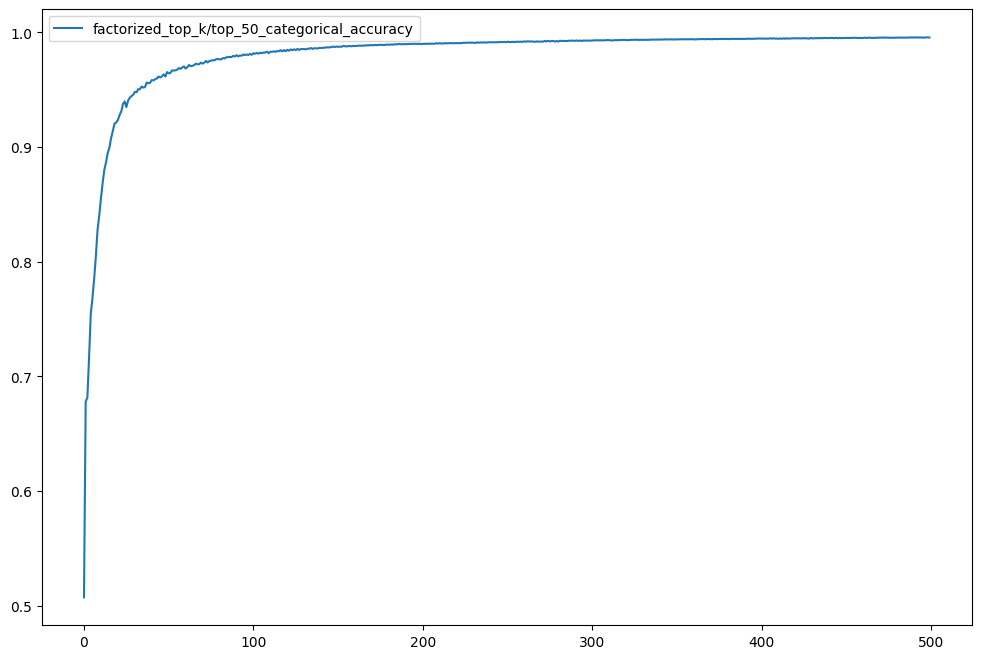

In [16]:
# plot all metrics

h = pd.DataFrame(history.history)
h[
    [
        "factorized_top_k/top_50_categorical_accuracy",
      
    ]
].plot(figsize=(12, 8))

In [17]:
metrics = model.evaluate(cached_test, return_dict=True)
metrics

2/2 [==============================] - 2s 160ms/step - root_mean_squared_error: 4.3675 - factorized_top_k/top_1_categorical_accuracy: 0.0093 - factorized_top_k/top_5_categorical_accuracy: 0.0676 - factorized_top_k/top_10_categorical_accuracy: 0.1352 - factorized_top_k/top_50_categorical_accuracy: 0.6423 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 11237.7650 - regularization_loss: 0.0000e+00 - total_loss: 11237.7650


{'root_mean_squared_error': 4.367459297180176,
 'factorized_top_k/top_1_categorical_accuracy': 0.009299442172050476,
 'factorized_top_k/top_5_categorical_accuracy': 0.06757594645023346,
 'factorized_top_k/top_10_categorical_accuracy': 0.13515189290046692,
 'factorized_top_k/top_50_categorical_accuracy': 0.6422814726829529,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 8704.677734375,
 'regularization_loss': 0,
 'total_loss': 8704.677734375}

In [18]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
index.index_from_dataset(
    tf.data.Dataset.zip(
        (schedules.batch(100), schedules.batch(100).map(model.candidate_model))
    )
)


_, titles = index(
    {
        "teacher": np.array(["HRS286"]),
        "sex": np.array([0]),
        "category": np.array(["Principal"]),
        "dedication": np.array(["Dedicación exclusiva"]),
        "age": np.array([67]),
        "semester": np.array(["2022-1"]),
    },
    k=50,
)

titles

<tf.Tensor: shape=(1, 50), dtype=string, numpy=
array([[b'MA-12', b'MA-11', b'JU-11', b'JU-12', b'MI-16', b'MI-17',
        b'MI-11', b'MA-10', b'MI-12', b'JU-10', b'MI-15', b'MI-14',
        b'MI-10', b'JU-9', b'LU-12', b'LU-11', b'MA-9', b'MI-18',
        b'LU-10', b'VI-15', b'VI-14', b'MI-9', b'VI-16', b'LU-14',
        b'LU-15', b'JU-15', b'JU-14', b'VI-17', b'MI-19', b'VI-11',
        b'LU-16', b'MA-8', b'VI-12', b'MA-15', b'MA-14', b'JU-16',
        b'LU-9', b'MA-7', b'MA-16', b'LU-17', b'JU-8', b'VI-10',
        b'MA-17', b'JU-17', b'JU-7', b'VI-18', b'MI-8', b'LU-18',
        b'MI-7', b'MA-18']], dtype=object)>

In [19]:
def best_k_predictions(teacher, sex, category, dedication, semester, age, k=10):
    all_pred = {}
    for sch in unique_schedules:
        _, _, score = model(
            {
                "teacher": np.array([teacher]),
                "sex": np.array([sex]),
                "category": np.array([category]),
                "dedication": np.array([dedication]),
                "age": np.array([age]),
                "schedule": np.array([sch]),
                "semester": np.array([semester]),
            }
        )
        all_pred[sch] = score.numpy()[0][0]

    return sorted(all_pred.items(), key=lambda x: x[1], reverse=True)[:k]


best_k_predictions("HRS286", 0, "Principal", "Dedicación exclusiva", "2023-1", 67, k=10)

[(b'MI-8', 8.0258665),
 (b'MA-16', 8.022888),
 (b'LU-16', 7.9748235),
 (b'MA-8', 7.948347),
 (b'MA-9', 7.863282),
 (b'VI-8', 7.8567853),
 (b'MI-7', 7.856101),
 (b'MA-10', 7.800258),
 (b'MA-17', 7.795181),
 (b'LU-17', 7.7817993)]